In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [2]:
DATA_DIR = "data/"

In [3]:
data = pd.read_pickle(DATA_DIR + "user-item.pkl")
data["test"] = np.random.random(len(data)) > 0.8

## Train LightFM

In [6]:
train_data = data[~data["test"]]
test_data = data[data["test"]]

In [7]:
dataset = ld.Dataset()
dataset.fit(data["user"], data["track"])

In [8]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [9]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=user_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=1, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [10]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2021-10-14 12:28:21,431] A new study created in memory with name: no-name-32fd1d29-5fce-4303-96f4-f44de0f3c046
[I 2021-10-14 12:28:22,911] Trial 0 finished with value: 0.0024627947714179754 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.001, 'max_sampled': 100, 'user_alpha': 0.0, 'item_alpha': 0.001}. Best is trial 0 with value: 0.0024627947714179754.
[I 2021-10-14 12:28:23,859] Trial 1 finished with value: 0.0001580403040861711 and parameters: {'loss': 'bpr', 'no_components': 10, 'learning_rate': 0.001, 'max_sampled': 10, 'user_alpha': 0.001, 'item_alpha': 0.0}. Best is trial 0 with value: 0.0024627947714179754.
[I 2021-10-14 12:28:24,932] Trial 2 finished with value: 0.0007638614624738693 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.01, 'max_sampled': 10, 'user_alpha': 0.001, 'item_alpha': 0.01}. Best is trial 0 with value: 0.0024627947714179754.
[I 2021-10-14 12:28:25,716] Trial 3 finished with value: 0.0018701436929404736 and 

In [11]:
best_params

{'loss': 'warp',
 'no_components': 50,
 'learning_rate': 0.01,
 'max_sampled': 100,
 'user_alpha': 0.0,
 'item_alpha': 0.01}

In [13]:
model, precisions_at = fit_model(
    epochs=30,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.002436454640701413 +/- 0.00035442013827443155
1:	0.0023837746120989323 +/- 0.0003508225131919655
2:	0.0024101147428154945 +/- 0.0003526264580751683
3:	0.002436454640701413 +/- 0.00035442013827443155
4:	0.002436454640701413 +/- 0.00035442013827443155
5:	0.002502304734662175 +/- 0.0003588608081333522
6:	0.002765705343335867 +/- 0.00037956928427300565
7:	0.0031212959438562393 +/- 0.0004045644600124867
8:	0.003582246834412217 +/- 0.00043370367719337035
9:	0.003871987573802471 +/- 0.00045497071972601123
10:	0.0041880677454173565 +/- 0.00047508057625697845
11:	0.004438298754394054 +/- 0.000489833482774912
12:	0.0048333993181586266 +/- 0.0005106280984663194
13:	0.005070459563285112 +/- 0.0005223804493337149
14:	0.005228499881923199 +/- 0.0005292019812099094
15:	0.005347029771655798 +/- 0.0005342454184477613
16:	0.005570921115577221 +/- 0.0005436085698607238
17:	0.00576847093179822 +/- 0.0005504907681138345
18:	0.0057157911360263824 +/- 0.0005483434381303524
19:	0.005794811528176069 +/- 0

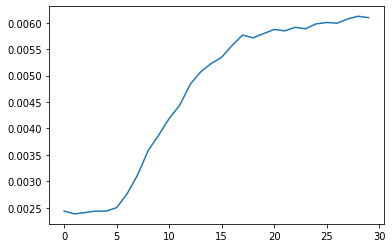

In [14]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [15]:
biases, embeddings = model.get_item_representations()

In [16]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [17]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [19]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [20]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [22]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": users[user_index],
            "tracks": top.tolist()
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|██████████| 9930/9930 [00:39<00:00, 251.43it/s]
